# Tutorial 3

In [1]:
import sympy as s 
from sympy.abc import x
import math 
import numpy as np
import matplotlib.pyplot as plt 
import plot_utils as pu # Make sure that your path is in the same folder! 
import importlib
import time
importlib.reload(pu)

from sympy.physics.vector import dynamicsymbols, init_vprinting # our symbols will be dynamic ones :) 
init_vprinting() # start newton notation

%matplotlib widget

## Jacobians
1. Bring back your 3DOF model from T1. But this time reduce it to only 1DOF (elbow flexion and extension)

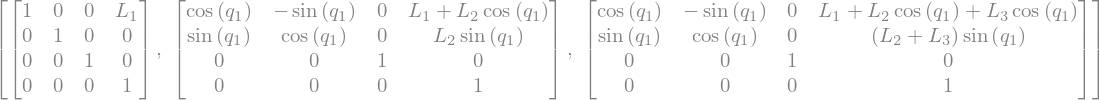

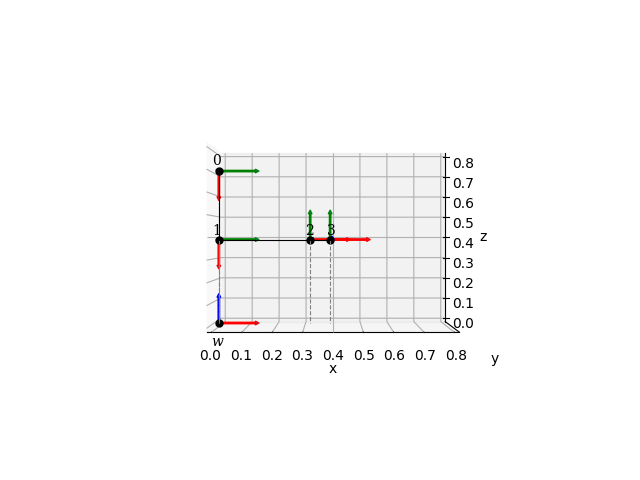

In [6]:
L1_ = 0.32 #Distance from your shoulder to your elbow [m]
L2_ = 0.32 #Distance from your elbow to your wrist [m]
L3_ = 0.07 #Distance from your wrist to the middle of your palm [m]

H0_w = np.array([[ 0, 1, 0,           0], \
                 [ 0, 0,-1,           0], \
                 [-1, 0, 0, L1_+L2_+L3_], \
                 [ 0, 0, 0,           1]]) 

pi = s.pi
q1, q2, q3 = dynamicsymbols('q1 q2 q3', real=True)
t = s.Symbol('t')
L1,L2,L3= s.symbols('L1 L2 L3', real=True)

# DH Table [theta|d|a|alpha] 
D = s.Matrix([[0,  0,  L1,  0], \
              [q1,  0,  L2,  0], \
              [0,  0,  L3,  0]])

# This function takes as input your DH table and creates a list of relative transformations
def calcTransformation(D):
    H = []
    for i in range(0,D.shape[0]):
        Hrel = s.Matrix([[s.cos(D[i,0]), -s.sin(D[i,0])*s.cos(D[i,3]) , s.sin(D[i,0])*s.sin(D[i,3]), D[i,2]*s.cos(D[i,0])],\
                         [s.sin(D[i,0]),  s.cos(D[i,0])*s.cos(D[i,3]) ,-s.cos(D[i,0])*s.sin(D[i,3]) ,D[i,2]*s.sin(D[i,0])],\
                         [0 ,           s.sin(D[i,3])     ,         s.cos(D[i,3])  ,           D[i,1]],\
                         [0  ,          0               ,         0        ,               1]])
        Hrel=s.simplify(Hrel)
        H.append(Hrel)
    return H

#relH[0] = H1_0
#relH[1] = H2_1
#relH[2] = H3_2
relH = calcTransformation(D)
relH

def calcTransformationAbs(H):
    absH = []
    for i in range (0,len(H)):
        if(i==0):
            H[i] = s.simplify(H[i])
            absH.append(H[i])
        else:
            absH_tmp = absH[i-1]*H[i]
            absH_tmp=s.simplify(absH_tmp)
            absH.append(absH_tmp)
    return absH

#absH[0] = H1_0
#absH[1] = H2_0
#absH[2] = H3_0
absH = calcTransformationAbs(relH)

def calcTransformationWorld(H0_w,H):
    wH = []
    for i in range(0,len(H)):
        wH_temp = H0_w*H[i]
        wH_temp = s.simplify(wH_temp)
        wH.append(wH_temp)
    return wH

#wH[0] = H1_w
#wH[1] = H2_w
#wH[2] = H3_w
wH = calcTransformationWorld(H0_w, absH)

def R2EulerA(R):
    d = s.sqrt(1-R[2,0]**2) # if you change it to minus it gives minus pi
    psi=s.atan2(R[2,1],R[2,2]) #x
    theta=s.atan2(-R[2,0],d)
    phi=s.atan2(R[1,0],R[0,0]) #z
    
    return psi,theta,phi

psi,theta,phi = R2EulerA(absH[2][0:3,0:3])
Xef_0 = s.Matrix([absH[2][0:3,3],psi,theta,phi])
Xef_0 = s.simplify(Xef_0)

psi,theta,phi = R2EulerA(wH[2][0:3,0:3])
Xef_w = s.Matrix([wH[2][0:3,3],psi,theta,phi])
Xef_w = s.simplify(Xef_w)

# change the angles 
H_list=[]
H = s.lambdify((x),s.Matrix(H0_w),modules="numpy")
H_list.append(H(0))
for wH_ in wH:
    H = s.lambdify((q1,q2,q3,L1,L2,L3,pi),wH_,modules="numpy")
    L1_ = 0.32
    L2_ = 0.32
    L3_ = 0.07
    q1_ = np.radians(90)
    H_list.append(H(q1_,0,0,L1_,L2_,L3_,np.pi))    

pu.plotTrans(H_list)
relH
absH

2. Calculate your DH table and homogeneous transformation to the center of mass. Assume the center of mass of the fore and upper arm are in the middle, and the center of mass of the hand is in the middle of the palm (same position as the end effector)

In [4]:
# calc Dcm 
L4 = L1/2
L5 = L2/2
L6 = L3
    
# DH Table [theta|d|a|alpha] 
Dcm = s.Matrix([[0,  0,  L4,  0], \
              [q1,  0,  L5,  0], \
              [0,  0,  L6,  0]])

#relHcm[0] = H1cm_0
#relHcm[1] = H2cm_1
#relHcm[2] = H3cm_2
relHcm = calcTransformation(Dcm)

def calcTransformationAbsCM(absH,Hcm):
    absHcm = []
    for i in range (0,len(Hcm)):
        if(i==0):
            absHcm.append(Hcm[i])
        else:
            absH_tmp = absH[i-1]*Hcm[i]
            absH_tmp=s.simplify(absH_tmp)
            absHcm.append(absH_tmp)
    return absHcm

#absHcm[0] = H1cm_0
#absHcm[1] = H2cm_0
#absHcm[2] = H3cm_0
absHcm = calcTransformationAbsCM(absH, relHcm)

#wHcm[0] = H1cm_w
#wHcm[1] = H2cm_w
#wHcm[2] = H3cm_w
wHcm = calcTransformationWorld(H0_w, absHcm)

3. Calculate your Jacobians for the end effector and each center of mass

In [6]:
z0 = s.Matrix([[0],[0],[1]])
# z1 = R1_0*z0
z1 = absH[0][0:3,0:3]*z0 
# z2 = R2_0*z0
z2 = absH[1][0:3,0:3]*z0 

#J1 = [z0x(t3_0);z0].T
J1 = s.Matrix([z0.cross(absH[2][0:3,3]),z0])
#J2 = [z1x(t3_0-t1_0);z1].T
J2 = s.Matrix([z1.cross(absH[2][0:3,3]-absH[0][0:3,3]),z1])
#J3 = [z2x(t3_0-t2_0);z2].T
J3 = s.Matrix([z2.cross(absH[2][0:3,3]-absH[1][0:3,3]),z2])

J3_0 = s.Matrix.hstack(J1,J2,J3)
J3_0 = s.simplify(J3_0)

#[z1x(t2_0);z1].T
J3_0 = s.simplify(s.Matrix([z1.cross(absH[1][0:3,3]-absH[0][0:3,3]),z1])) # for 1DOF 
s.pprint(J3_0)

#absHcm[0] = H1cm_0
#absHcm[1] = H2cm_0
#absHcm[2] = H3cm_0

#J1 = [z0x(t3_0);z0].T
J1 = s.Matrix([z0.cross(absHcm[0][0:3,3]),z0])
#J2 = 0
J2 = s.Matrix([0,0,0,0,0,0])
#J3 = 0
J3 = s.Matrix([0,0,0,0,0,0])

Jcm1_0 = s.Matrix.hstack(J1,J2,J3)
Jcm1_0 = s.simplify(Jcm1_0)
Jcm1_0 = s.simplify(J1) #for 1DOF

#J1 = [z0x(t3_0);z0].T
J1 = s.Matrix([z0.cross(absHcm[1][0:3,3]),z0])
#J2 = [z1x(tcm2_0-t1_0);z1].T
J2 = s.Matrix([z1.cross(absHcm[1][0:3,3]-absH[0][0:3,3]),z1])
#J3 = 0
J3 = s.Matrix([0,0,0,0,0,0])

Jcm2_0 = s.Matrix.hstack(J1,J2,J3)
Jcm2_0 = s.simplify(Jcm2_0)
Jcm2_0 = s.simplify(J2) #for 1DOF
s.pprint(Jcm2_0)

#J1 = [z0x(tcm3_0);z0].T
J1 = s.Matrix([z0.cross(absHcm[2][0:3,3]),z0])
#J2 = [z1x(tcm3_0-t1_0);z1].T
J2 = s.Matrix([z1.cross(absHcm[2][0:3,3]-absH[0][0:3,3]),z1])
#J3 = [z2x(tcm3_0-t2_0);z2].T
J3 = s.Matrix([z2.cross(absHcm[2][0:3,3]-absH[1][0:3,3]),z2])

Jcm3_0 = s.Matrix.hstack(J1,J2,J3)
Jcm3_0 = s.simplify(Jcm3_0)
Jcm3_0 = s.simplify(J1) #for 1DOF

⎡-L₂⋅sin(q₁(t))⎤
⎢              ⎥
⎢L₂⋅cos(q₁(t)) ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎣      1       ⎦
⎡-L₂⋅sin(q₁(t)) ⎤
⎢───────────────⎥
⎢       2       ⎥
⎢               ⎥
⎢ L₂⋅cos(q₁(t)) ⎥
⎢ ───────────── ⎥
⎢       2       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎣       1       ⎦


In [7]:
Jcm2_0

/home/natalia/.spyder-env/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/natalia/.spyder-env/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/natalia/.spyder-env/lib/python3.8/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/home/natalia/.spyder-env/lib/python3.8/site-packages/IPython/lib/latextools.py:126: M

⎡-L₂⋅sin(q₁) ⎤
⎢────────────⎥
⎢     2      ⎥
⎢            ⎥
⎢ L₂⋅cos(q₁) ⎥
⎢ ────────── ⎥
⎢     2      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎣     1      ⎦

In [9]:
J3_0

⎡-L₂⋅sin(q₁)⎤
⎢           ⎥
⎢L₂⋅cos(q₁) ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎣     1     ⎦

## Dynamic Model 

4. Compute the inertia matrix M(q)

In [11]:
m1,m2,m3= s.symbols('m1 m2 m3', real=True)
I111,I122,I133= s.symbols('I111 I122 I133', real=True)
I211,I222,I233= s.symbols('I211 I222 I233', real=True)
I311,I322,I333= s.symbols('I311 I322 I333', real=True)

Icm1 = s.Matrix([[I111,0,0],
                 [0,I122,0],
                 [0,0,I133]])

Icm2 = s.Matrix([[I211,0,0],
                 [0,I222,0],
                 [0,0,I233]])

Icm3 = s.Matrix([[I311,0,0],
                 [0,I322,0],
                 [0,0,I333]])

M = s.simplify(Jcm2_0[0:3,0:3].T*Jcm2_0[0:3,0:3]*m2 + Jcm2_0[3:6,0:3].T*(absHcm[1][0:3,0:3]*Icm2*absHcm[1][0:3,0:3].T)*Jcm2_0[3:6,0:3])
M

⎡         2   ⎤
⎢       L₂ ⋅m₂⎥
⎢I₂₃₃ + ──────⎥
⎣         4   ⎦

5. Compute the maxtrix of Coriolis and Centripetal effects

In [12]:
q = s.Matrix([q1,q2,q3])
C = s.zeros(M.shape[0])
for k in range(0,C.shape[0]):
    for j in range(0,C.shape[1]):
           for i in range(0,q.shape[0]):
               C[k,j] += (M[0].diff(q1) + M[0].diff(q1) - M[0].diff(q1))*q1.diff()
           C[k,j] *= 1/2
C = s.simplify(C)
C

[0]

6. Compute the vector of graviational torques G(q)

In [13]:
g,gx,gy,gz = s.symbols('g gx gy gz', real=True)
gVector = s.Matrix([[gx],[gy],[gz]])
k1,theta1,b1 = s.symbols('k1 theta1 b1', real=True)
k2,theta2,b2 = s.symbols('k2 theta2 b2', real=True)
k3,theta3,b3 = s.symbols('k3 theta3 b3', real=True)
m = s.Matrix([m1,m2,m3])
k = s.Matrix([k1,k2,k3])
theta = s.Matrix([theta1,theta2,theta3])

P = 0
G = s.zeros(len(q),1)
for i in range(0,len(m)):
    P += (m[i]*gVector.T*absHcm[i][0:3,3])[0] + 1/2*k[i]*(q[i]-theta[i])**2

for k in range(0,len(q)):
    G[k] = P.diff(q[k])

P = 0
G = 0
P = (m2*gVector.T*absHcm[1][0:3,3])[0] + 1/2*k1*(q1-theta1)**2
G = P.diff(q1)    
G = s.simplify(G)
G

7. Calculate B vector 

In [14]:
D = 0
B = s.zeros(1,1)
D = 1/2*b1*q1.diff()**2
B = s.simplify(D.diff(q1.diff()))
B  

Let's move now to our ros w_s 